In [77]:
import sklearn
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from utilities import EdwinRueda_utils
%matplotlib inline
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, export_svgs
from bokeh.transform import jitter
from bokeh.models import ColumnDataSource
output_notebook()
print("sklearn version: ", sklearn.__version__)
print("numpy version: ", np.__version__)
print("pandas version: ", pd.__version__)

Loading BokehJS ...

sklearn version:  0.23.2
numpy version:  1.18.1
pandas version:  1.1.3


<center> <h1> Selecting the best SMOTE algorithm </h1>

<b>Autor:</b> Edwin Rueda <br>
<b>email:</b> ejrueda95g@gmail.com <br>
<b>github:</b> https://github.com/ejrueda <br>
<b>website:</b> http://edwinrueda.com/ <br>
<b> You can cite this work with</b>:

@software{edwin_rueda_2020_3843381,<br>
  author       = {Edwin Rueda},<br>
  title        = {ejrueda/MasterUFPA: zenodo release},<br>
  month        = may,<br>
  year         = 2020,<br>
  publisher    = {Zenodo},<br>
  version      = {zenodo},<br>
  doi          = {10.5281/zenodo.3843381},<br>
  url          = {https://doi.org/10.5281/zenodo.3843381}<br>
}

- In this notebook we focus in the selection of the best SMOTE algorithm configuration to generate the best synthetic samples.<br><br>
Note: If you want to know how the SMOTE algorithm works, go to the notebook called <b>SMOTE algorithm</b>.

#### SMOTE algorithm
- In the SMOTE algorithm two parameters can be adjusted:
    - <b>k</b>: this parameter represents the number of neighbors to take into account.
    - <b>s</b>: this parameter represents the standard desviation of the noise vector. remember that the noise vector is based in a gaussian distribution.
    
Note: the real dataset is augmented by 100 percent.

In [15]:
def smote(T, N, k, s):
    """
    Inputs:
        T: 2D-data array to be increase
        N: Amount of SMOTE N%. between (0, 100]
        k: Number of nearest neighbors
        s: standard desviation of the noise vector
    Ouput:
    (N/100)* T synthetic minority class samples
    (∗ If N is less than 100%, randomize the minority class samples as only a random
       percent of them will be SMOTEd. ∗)
    """
    if N < 100:
        idxs = np.random.choice(range(len(T)), size=int(len(T)*(N/100)), replace=False)
        T = T[idxs, :]
        N = 100
        
    N = int(N/100)*len(T)
    synthetic = np.ones((N, T.shape[1]))
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)
    #generating synthetic samples
    for i in range(N):
        #print(i)
        idx = np.random.randint(low=0, high=T.shape[0])
        T_sample = T[idx] #x_i random sample
        #print(T_sample.shape)
        #getting the k-nearest neighbors
        nn = neigh.kneighbors(T_sample.reshape(1,T.shape[1]), return_distance=False)
        #getting random k-neighbors index
        nn_index = np.random.choice(nn[0])
        while (T_sample == T[nn_index]).all():
            nn_index = np.random.choice(nn[0])
        dif = T_sample - T[nn_index]
        gap = np.random.normal(scale=s)
        synthetic[i] = T_sample + gap*dif
    
    return synthetic

### Metric to select the best SMOTE parameters
$$S(x,x') = \sum_{i}^{m}\sum_{j}^{n_g}\sum_{k}^{n_f}\frac{\vert x_{i}^{(k)}- x_{j}^{'(k)}\vert}{n_f n_g m}$$
- where $x$ are the synthetic samples and $x'$ are the real samples.

In [16]:
data = pd.read_csv("../data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
data.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


In [17]:
rg = open("../data/reference_genes.txt").read().splitlines()
print(rg)

['cysG', 'hcaT', 'idnT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [18]:
rg_data = data.reindex(rg).dropna()
rg_data

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


In [19]:
## crear la clase gridsearchcv para el algoritmo smote
class smote_gridsearch:
    """
    This class allows find the best parameters in the smote algorithm
    """
    def score(self, synthetic, real):
        dist = []
        for i in range(real.shape[0]):
            dist.append(np.mean(abs(real[i] - synthetic)))
        return np.mean(dist)
    
    def get_best_params(self, X, k_v, s_v, n_iter):
        """
        function to get the best params:
        input:
            - X: real data augmented by the smote algorithm
            - smote: function that implement the smote algorithm, with T,N,k and s as inputs
            - k_v: vector with the k-values to tested (k=k-nearest neighbors)
            - s_v: vector with the s-values to tested (s=standard desviation of the noise vector)
            - n_iter: number of iterations in each pair of parameters.
        """
        grid = {}
        heatmap_matrix = np.zeros((len(k_v), len(s_v)))
        r = 0 #to handle indexing of the heatmap_matrix
        for k in k_v:
            c = 0
            for s in s_v:
                aux_score = []
                for i in range(n_iter):
                    synthetic_samples = smote(X, N=100, k=k+1, s=s)
                    aux_score.append(self.score(synthetic_samples, X))
                grid[(k,s)] = aux_score
                heatmap_matrix[r][c] = np.mean(aux_score)
                c +=1 
            r += 1
        return grid, heatmap_matrix

In [59]:
tic = time()
sgs = smote_gridsearch()
k = np.arange(1,6)
s = np.linspace(start=0.1, stop=1, num=20)
sgs_results, heatmap_matrix = sgs.get_best_params(np.array(rg_data), k, s, n_iter=30)
toc = time()
print("execution time:",(toc-tic), "[s]")

execution time: 30.274513006210327 [s]


In [60]:
min_value = np.inf
min_index = None
for i in list(sgs_results.keys()):
    #print(i, np.mean(sgs_results[i]))
    if np.mean(sgs_results[i]) < min_value:
        min_value = np.mean(sgs_results[i])
        min_index = i

In [61]:
min_index, min_value

((5, 0.1473684210526316), 4.857434164392864)

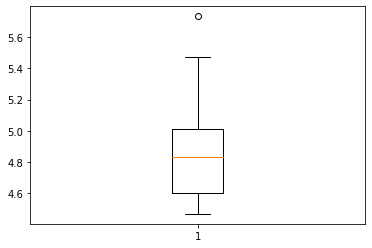

In [62]:
plt.boxplot(sgs_results[min_index]);

In [105]:
bk_utils = EdwinRueda_utils.bokeh_utils()
[lower, q25, q50, q75, upper], outliers = bk_utils.boxtplot_values(np.array(sgs_results[min_index]))

x_ticks = ["1"]
p = figure(x_range=x_ticks, width=230, height=250)
#lower and upper rects
p.rect(x_ticks, lower, width=.12, height=.005, line_color="black")
p.rect(x_ticks, upper, width=.12, height=.005, line_color="black")
#segments
p.segment(x_ticks, lower, x_ticks, q25, line_color="black", line_width=2)
p.segment(x_ticks, q75, x_ticks, upper, line_color="black", line_width=2)
#vars
p.vbar(x_ticks, 0.28, q50, q25, line_color="black", fill_color="#E08E79", line_width=2)
p.vbar(x_ticks, 0.28, q50, q75, line_color="black", fill_color="#3B8686", line_width=2)
#p.xaxis.axis_label = "conjunto de dados"
p.yaxis.axis_label = "Sm metric"
p.xgrid.grid_line_color = None
#p.ygrid.grid_line_color = "#F3F2F2"

#outliers
if len(outliers!=0):
    p.circle([x_ticks[0]]*len(outliers), outliers, color="orange", line_width=5)

show(p)
p.output_backend = "svg"
export_svgs(p, filename="./results/boxplot_smote_gridsearch.svg")

['./results/boxplot_smote_gridsearch.svg']

Note: entre mas pequeña sea la desviación estandar menos ruido se añade, por ende se generan mas de los mismos ejemplos.

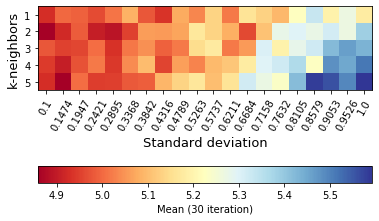

In [63]:
fig, ax = plt.subplots()
im = ax.imshow(heatmap_matrix, cmap="RdYlBu")
ax.set_xticks(range(len(s)))
ax.set_yticks(range(len(k)))
#para colocarle los valores a los ejes
ax.set_xticklabels(np.round(s,4), rotation=60);
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_yticklabels(k);
ax.set_xlabel("Standard deviation", fontsize=13)
ax.set_ylabel("k-neighbors", fontsize=13)
cbar = ax.figure.colorbar(im, orientation="horizontal", pad=.35, );
cbar.ax.set_xlabel("Mean (30 iteration)");
plt.savefig("./results/selecting_best_parameters_SMOTE.svg")

In [ ]:
from sklearn.decomposition import PCA

syn_samples = smote(np.array(rg_data), N=300, k=min_index[0], s=min_index[1])
pca = PCA(n_components=2)
rg_data_pca = pca.fit_transform(rg_data)
syn_samples_pca = pca.transform(syn_samples)
plt.scatter(syn_samples_pca[:,0], syn_samples_pca[:,1], label="Sintéticos");
plt.scatter(rg_data_pca[:,0], rg_data_pca[:,1], label="Reais");
plt.legend();

### Conclusions:
- the smote algorithm does not generate new samples, the samples are based on alterations to existing examples.

Next notebook: comparing different augmentation methods